# Восстановление золота из руды

***Описание проекта***

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

***Описание данных***

Технологический процесс

* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
    * Xanthate — ксантогенат (промотер, или активатор флотации);
    * Sulphate — сульфат (на данном производстве сульфид натрия);
    * Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

Параметры этапов

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

## Подготовка данных

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Откроем файлы и запишем датасеты в переменные train, test и full
try:
    train = pd.read_csv('/datasets/gold_industry_train.csv')
    test = pd.read_csv('/datasets/gold_industry_test.csv')
    full = pd.read_csv('/datasets/gold_industry_full.csv')
except:
    train = pd.read_csv('gold_industry_train.csv')
    test = pd.read_csv('gold_industry_test.csv')
    full = pd.read_csv('gold_industry_full.csv')

In [3]:
# Посмотрим первые 10 строк датафрейма train
train.head(10)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686
5,2016-01-15 05:00:00,5.687168,5.801920,1.879351,35.470082,546.173470,57.469578,11.072517,6.200383,999.934134,...,9.302669,41.633678,6.482968,10.049416,5.480257,69.465816,1.918586,10.182708,0.664118,16.999638
6,2016-01-15 06:00:00,6.038436,6.056253,2.105501,34.920570,523.376439,56.674647,11.535899,6.204974,999.832373,...,9.103047,41.995316,6.533849,10.058141,4.569100,69.300835,2.058913,10.304598,0.807342,16.723575
7,2016-01-15 07:00:00,6.433854,5.955053,2.310432,36.091386,549.842749,56.730325,12.557906,6.799275,1000.166602,...,9.369209,42.452727,6.130823,9.935481,4.389813,70.230976,2.143437,10.443288,0.949346,16.689959
8,2016-01-15 08:00:00,6.526612,5.878084,2.391713,35.753879,560.115242,56.649893,13.166128,6.798659,1000.026864,...,9.437044,43.404078,5.834140,10.071156,4.876389,69.688595,2.209881,10.420140,1.065453,17.201948
9,2016-01-15 09:00:00,6.747693,5.974832,2.539114,38.553938,566.616045,60.308763,13.996130,6.800263,1000.332327,...,9.582874,43.487291,5.706261,10.242511,5.214161,70.973641,2.200997,10.473539,1.171183,17.717049


In [4]:
# Посмотрим первые 10 строк латафрейма test
test.head(10)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805
5,2017-12-09 19:59:59,5.848338,6.234198,4.468803,37.816555,547.515088,85.875864,8.040386,7.500718,1201.408796,...,22.977833,-499.910098,20.000113,-500.584093,18.003899,-500.326371,12.978611,-499.966502,19.988673,-500.742891
6,2017-12-09 20:59:59,6.172839,6.213598,4.458071,36.829223,518.363800,73.426294,7.641859,7.498470,1198.551240,...,22.964590,-500.083299,20.010567,-500.545746,18.040164,-498.936442,12.988702,-499.985412,20.014155,-499.443855
7,2017-12-09 21:59:59,5.743825,6.264367,4.428267,37.170131,500.494798,75.915232,7.230213,7.496599,1201.172468,...,23.010484,-500.498525,20.043525,-499.701442,17.991164,-500.324632,13.000809,-500.181711,20.001605,-500.229965
8,2017-12-09 22:59:59,5.558520,6.167472,4.370640,37.356892,540.990643,79.668503,7.089240,7.524634,1195.305111,...,22.979813,-500.451722,19.995022,-500.415107,18.057379,-499.238503,13.011922,-500.067255,20.002796,-504.347015
9,2017-12-09 23:59:59,5.473143,6.076597,4.274908,38.631317,492.146649,90.792119,7.367698,6.543369,1203.076302,...,23.050901,-501.185001,20.016755,-499.840744,17.991566,-500.303770,13.023215,-500.018271,20.015115,-515.537548


In [5]:
# Посмотрим первые 10 строк латафрейма full
full.head(10)

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686
5,2016-01-15 05:00:00,5.687168,5.801920,1.879351,35.470082,546.173470,57.469578,11.072517,6.200383,999.934134,...,9.302669,41.633678,6.482968,10.049416,5.480257,69.465816,1.918586,10.182708,0.664118,16.999638
6,2016-01-15 06:00:00,6.038436,6.056253,2.105501,34.920570,523.376439,56.674647,11.535899,6.204974,999.832373,...,9.103047,41.995316,6.533849,10.058141,4.569100,69.300835,2.058913,10.304598,0.807342,16.723575
7,2016-01-15 07:00:00,6.433854,5.955053,2.310432,36.091386,549.842749,56.730325,12.557906,6.799275,1000.166602,...,9.369209,42.452727,6.130823,9.935481,4.389813,70.230976,2.143437,10.443288,0.949346,16.689959
8,2016-01-15 08:00:00,6.526612,5.878084,2.391713,35.753879,560.115242,56.649893,13.166128,6.798659,1000.026864,...,9.437044,43.404078,5.834140,10.071156,4.876389,69.688595,2.209881,10.420140,1.065453,17.201948
9,2016-01-15 09:00:00,6.747693,5.974832,2.539114,38.553938,566.616045,60.308763,13.996130,6.800263,1000.332327,...,9.582874,43.487291,5.706261,10.242511,5.214161,70.973641,2.200997,10.473539,1.171183,17.717049


In [6]:
# Выведем общую информацию о датафрейме train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


In [7]:
# Выведем общую информацию о датафрейме test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

In [8]:
# Выведем общую информацию о датафрейме full
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


In [9]:
train.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,14579.000000,14579.000000,14507.000000,14502.000000,14572.000000,14478.000000,14548.000000,14572.000000,14579.000000,14579.000000,...,13659.000000,14579.000000,14578.000000,14578.000000,14387.000000,14579.000000,14579.000000,14578.000000,14504.000000,14574.000000
mean,8.352941,8.877460,3.604221,36.561420,474.332784,58.922712,12.427399,5.994854,1104.208278,-379.367166,...,7.111347,43.979499,5.192145,9.923809,9.566676,66.759066,3.087939,9.731972,2.719985,10.612745
std,1.934376,1.922536,1.056063,5.209823,108.503552,22.407410,3.428939,1.152873,162.235606,94.652311,...,3.909951,5.471437,1.388014,1.706976,2.805654,10.619709,0.915187,2.358143,0.958929,2.871075
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.049194,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.932996,7.341922,2.880490,34.093951,411.048483,47.278490,10.002832,5.304167,999.644856,-499.861797,...,3.784897,43.345906,4.283347,9.103183,7.860030,63.114596,2.505287,8.088928,2.036512,9.013412
50%,8.225284,8.715859,3.532399,37.097511,498.187968,54.361187,12.003320,6.003053,1000.982624,-300.314199,...,7.629968,44.975014,5.118647,10.046455,9.301970,67.962788,3.029238,9.818512,2.774847,10.670515
75%,9.832210,10.255843,4.257282,39.899799,549.586552,64.464926,14.929903,6.796632,1292.663971,-299.989315,...,10.367050,46.275153,5.925380,10.981203,11.001573,72.598187,3.614098,11.169187,3.353845,12.130827
max,13.731330,14.596026,7.052325,53.475325,717.508837,484.967466,36.118275,9.703448,1512.299531,-273.776101,...,26.000772,52.756638,16.001945,16.705297,19.423912,100.000000,8.245022,19.552149,5.804178,22.317730


In [10]:
test.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,4860.000000,4860.000000,4832.000000,4838.000000,4856.000000,4816.000000,4857.000000,4859.000000,4859.000000,4859.000000,...,4.859000e+03,4859.000000,4.859000e+03,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000,4859.000000
mean,8.005584,8.547348,3.579662,37.095864,490.285103,59.113400,12.055735,6.101308,1108.635895,-368.340127,...,1.985770e+01,-488.665140,1.557025e+01,-464.176507,16.594103,-490.815250,12.945971,-489.583564,19.053888,-504.678924
std,1.993590,1.958601,1.029377,4.926284,94.371623,19.125122,3.407642,1.042754,156.493143,91.155929,...,5.913105e+00,44.392714,4.927361e+00,65.706994,5.724305,32.258443,5.533176,37.084609,5.548996,38.690186
min,0.010000,0.010000,0.010000,0.010000,0.012786,0.046369,0.018907,0.015783,300.792494,-600.568138,...,1.079872e-16,-799.704969,2.489718e-17,-799.860767,-0.371498,-797.142475,1.358469,-800.006180,0.160386,-809.734800
25%,6.574363,6.975898,2.903612,34.510841,434.099695,47.596984,9.890429,5.499808,999.715729,-499.731972,...,1.501123e+01,-500.704004,1.202172e+01,-500.196517,11.073822,-500.483564,9.011890,-500.129913,14.963953,-500.668501
50%,7.812923,8.179714,3.540772,37.499761,502.118742,55.509481,11.997859,6.099805,1001.414798,-300.181367,...,1.996807e+01,-499.892919,1.501240e+01,-499.540776,16.631195,-499.873136,11.999417,-499.955304,19.960006,-500.033769
75%,9.556589,10.084339,4.199847,40.461315,555.596563,66.661547,14.496072,6.802101,1202.837565,-299.961547,...,2.498900e+01,-498.652030,1.999949e+01,-400.302329,19.983191,-498.852815,15.004198,-499.643776,24.974583,-499.460134
max,13.417156,14.533698,7.142594,53.477742,702.523396,363.989699,30.010759,9.396928,1521.980372,-281.039299,...,3.008450e+01,-383.373053,2.398898e+01,-114.250832,33.215996,-288.963521,24.177106,-141.934397,32.028529,-104.427459


In [11]:
full.describe()

,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
count,19439.000000,19439.000000,19339.000000,19340.000000,19428.000000,19294.000000,19405.000000,19431.000000,19438.000000,19438.000000,...,17691.000000,19439.000000,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000
mean,8.266097,8.794927,3.598085,36.695114,478.320042,58.970310,12.334373,6.021474,1105.315068,-376.610690,...,7.167247,44.076513,5.168470,9.978895,9.501224,67.050208,3.042467,9.688589,2.705795,10.583728
std,1.955092,1.936847,1.049486,5.145445,105.373758,21.634478,3.427317,1.127263,160.826798,93.909667,...,3.916079,5.129784,1.372348,1.669240,2.787537,10.125840,0.922808,2.328642,0.949077,2.868782
min,0.010000,0.010000,0.010000,0.010000,0.002986,0.046369,0.001083,0.000568,-0.042069,-657.949759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.854384,7.237967,2.887280,34.207799,416.525453,47.435103,10.000362,5.398678,999.661867,-499.835165,...,3.845475,43.402215,4.251240,9.137262,7.722820,63.299712,2.461138,8.062878,2.040119,8.938947
50%,8.125839,8.593574,3.534895,37.202650,499.416120,54.610197,12.001174,6.008273,1001.072890,-300.263994,...,7.685827,45.011244,5.066094,10.102433,9.218961,68.172738,2.984909,9.743623,2.748730,10.622456
75%,9.769917,10.213771,4.244161,40.039133,550.172183,65.023044,14.716595,6.798051,1205.620588,-299.981998,...,10.411296,46.275313,5.895527,11.035769,10.947813,72.686642,3.571351,11.134294,3.333216,12.104271
max,13.731330,14.596026,7.142594,53.477742,717.508837,484.967466,36.118275,9.703448,1521.980372,-273.776101,...,26.000772,52.756638,16.001945,17.031899,19.615720,100.000000,8.245022,19.552149,5.804178,22.317730


***Рассчет эффективности обогащения***

In [12]:
# Рассчитаем эффективность обогащения на обучающей выборке
C = train['rougher.output.concentrate_au']
F = train['rougher.input.feed_au']
T = train['rougher.output.tail_au']

In [13]:
# Сохраним данные
train['recovery_check'] = ((C*(F-T))/(F*(C-T)))*100
train['recovery_check'].mean()

82.52119968211336

In [14]:
# Сравним с rougher.output.recovery
train['rougher.output.recovery'].mean()

82.52119968211336

Значение совпадает, значит можно сделать вывод, что эффективность обогащения рассчитана правильно.

***Рассчет MAE***

In [15]:
# Найдем MAE между расчётами и значением признака
mean_absolute_error(train['recovery_check'], train['rougher.output.recovery'])

9.83758577644259e-15

Значение MAE минимальное, значит можно сделать вывод, что эффективность обогащения рассчитана правильно

In [16]:
# Удалим данные
train.drop('recovery_check', axis=1, inplace=True)

***Признаки, недоступные в тестовой выборке***

In [17]:
# Найдем признаки недоступные в тестовой выборке
set(train.columns)-set(test.columns) 

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Из 34 пропущенных признака 30 относятся к параметрам продукта и только 4 к расчетным характеристикам.
Они не могут быть доступны в начале технического процесса и становятся известны позднее.

***Предобработка данных***

In [18]:
# Посчитаем пропуски в датасете train
train.isna().sum()

date                       0
rougher.input.feed_au      0
rougher.input.feed_ag      0
rougher.input.feed_pb     72
rougher.input.feed_sol    77
                          ..
final.output.recovery      0
final.output.tail_au       0
final.output.tail_ag       1
final.output.tail_pb      75
final.output.tail_sol      5
Length: 87, dtype: int64

In [19]:
# Посчитаем пропуски в датасете test
test.isna().sum()

date                                            0
rougher.input.feed_au                           0
rougher.input.feed_ag                           0
rougher.input.feed_pb                          28
rougher.input.feed_sol                         22
rougher.input.feed_rate                         4
rougher.input.feed_size                        44
rougher.input.floatbank10_sulfate               3
rougher.input.floatbank10_xanthate              1
rougher.state.floatbank10_a_air                 1
rougher.state.floatbank10_a_level               1
rougher.state.floatbank10_b_air                 1
rougher.state.floatbank10_b_level               1
rougher.state.floatbank10_c_air                 1
rougher.state.floatbank10_c_level               1
rougher.state.floatbank10_d_air                 0
rougher.state.floatbank10_d_level               0
rougher.state.floatbank10_e_air                 7
rougher.state.floatbank10_e_level               0
rougher.state.floatbank10_f_air                 0


In [20]:
# Посчитаем пропуски в датасете full
full.isna().sum()

date                        0
rougher.input.feed_au       0
rougher.input.feed_ag       0
rougher.input.feed_pb     100
rougher.input.feed_sol     99
                         ... 
final.output.recovery       0
final.output.tail_au        0
final.output.tail_ag        1
final.output.tail_pb      101
final.output.tail_sol       6
Length: 87, dtype: int64

In [21]:
# Заполним пропуски
train.fillna(method='ffill', inplace=True)
test.fillna(method='ffill', inplace=True)
full.fillna(method='ffill', inplace=True)

In [22]:
# Проверим
print(train.isna().sum())
print(' ')
print(test.isna().sum())
print(' ')
print(full.isna().sum())

date                      0
rougher.input.feed_au     0
rougher.input.feed_ag     0
rougher.input.feed_pb     0
rougher.input.feed_sol    0
                         ..
final.output.recovery     0
final.output.tail_au      0
final.output.tail_ag      0
final.output.tail_pb      0
final.output.tail_sol     0
Length: 87, dtype: int64
 
date                                          0
rougher.input.feed_au                         0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_sol                        0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.state.floatbank10_a_air               0
rougher.state.floatbank10_a_level             0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_b_level             0
rougher.state.floatbank10_c_air          

***Вывод:*** Файлы содержат разное количество записей: train - 14579, test - 4860, full - 19439. Количество значений в столбцах различается, что говорит о том, что есть пропущенные значения. Наименования столбцов корректны. Проверено, что эффективность обогащения рассчитана правильно. Найдено MAE между расчётами и значением признака. Выполнена предобработка данных.

## Анализ данных

***Как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки***

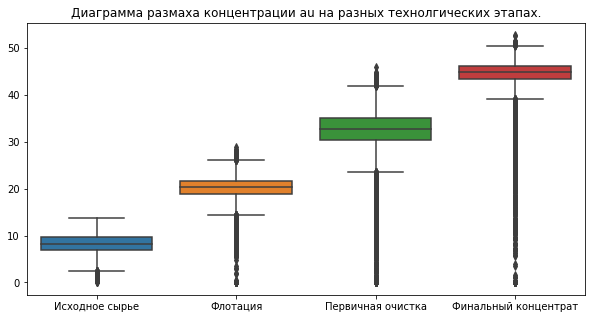

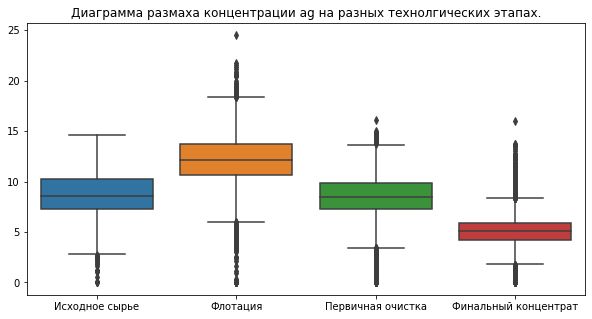

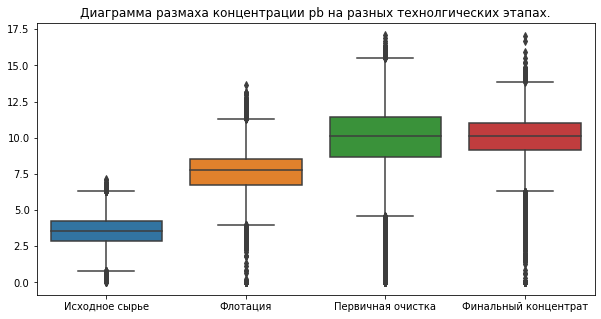

In [23]:
# Построим диаграммы
elements = {'au': 'au',
            'ag': 'ag',
            'pb': 'pb'}

for key in elements.keys(): 
    plt.figure(figsize=(10,5))
    plt.title('Диаграмма размаха концентрации {} на разных технолгических этапах.'.format(elements[key]))
    sns.boxplot(data=full[['rougher.input.feed_' + elements[key],
                           'rougher.output.concentrate_' + elements[key], 
                           'primary_cleaner.output.concentrate_'+ elements[key], 
                           'final.output.concentrate_' + elements[key],]])
    plt.xticks([0,1,2,3], ['Исходное сырье', 'Флотация', 'Первичная очистка', 'Финальный концентрат'])
plt.show()



Концентрация золота плавно увеличивается на всех этапах.

Концентрация серебра увеличивается во время флотации, а затем плавно уменьшается на всех этапах.

Концентрация свинца увеличивается от стадии флотации до стадии первичной очистки, далее увеличивается плавно.

***Сравнение распределения размеров гранул исходного сырья на обучающей и тестовой выборках***

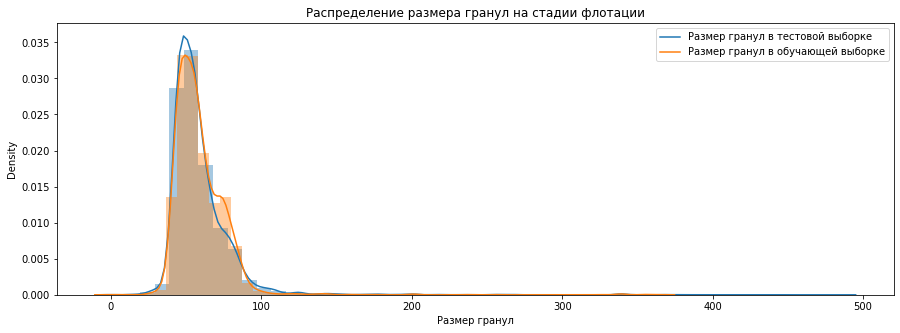

In [24]:
# Построим графики
fig = plt.figure(figsize=(15, 5))
sns.distplot(train['rougher.input.feed_size'])
sns.distplot(test['rougher.input.feed_size'])
plt.title('Распределение размера гранул на стадии флотации')
plt.xlabel('Размер гранул')
plt.legend(labels=['Размер гранул в тестовой выборке','Размер гранул в обучающей выборке'])
plt.show()

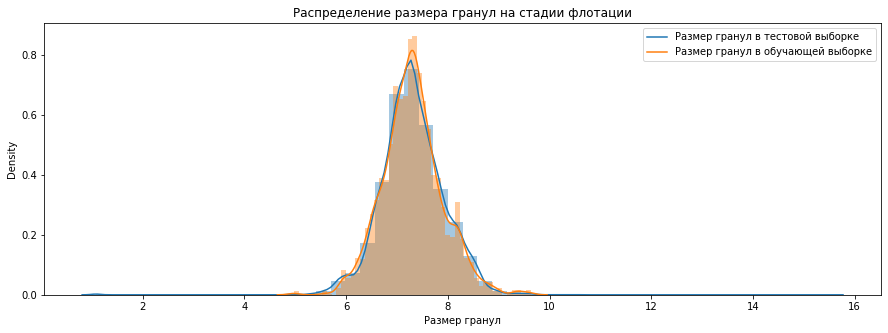

In [25]:
fig = plt.figure(figsize=(15, 5))
sns.distplot(train['primary_cleaner.input.feed_size'])
sns.distplot(test['primary_cleaner.input.feed_size'])
plt.title('Распределение размера гранул на стадии флотации')
plt.xlabel('Размер гранул')
plt.legend(labels=['Размер гранул в тестовой выборке','Размер гранул в обучающей выборке'])
plt.show()

Распределения размеров гранул сырья на обучающей и тестовых выборках не имеют значительных отличий.

Перед первичной очисткой размер гранул снижается практически в 10 раз, что говорит о их расщеплении во время флотации.

***Суммарная концентрация металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате***

In [26]:
rouger_input_sum = (full['rougher.input.feed_au'] +
                     full['rougher.input.feed_ag'] +
                     full[ 'rougher.input.feed_pb'])

rouger_output_sum = (full['rougher.output.concentrate_au'] +
                       full['rougher.output.concentrate_ag'] +
                       full['rougher.output.concentrate_pb'])

final_output_sum = (full['final.output.concentrate_au'] +
                     full['final.output.concentrate_ag'] +
                     full['final.output.concentrate_pb'])

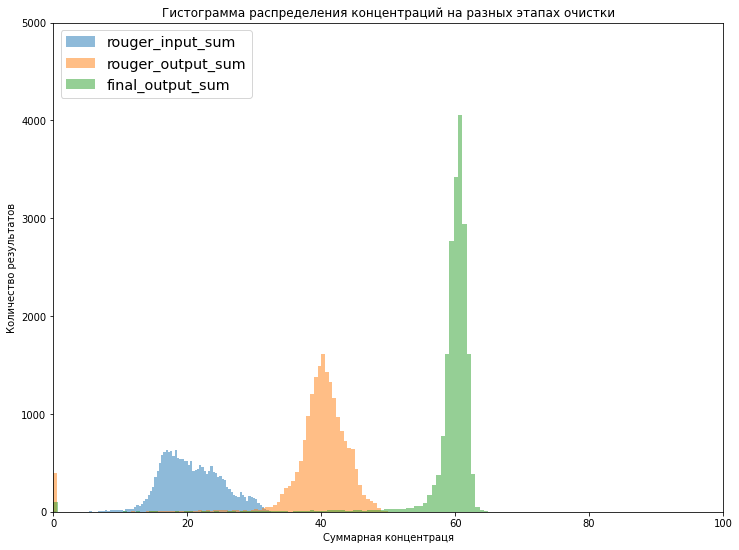

In [27]:
plt.figure(figsize=[12,9])

plt.hist(rouger_input_sum, bins=100, label = 'rouger_input_sum', alpha=.5)
plt.hist(rouger_output_sum, bins=100, label = 'rouger_output_sum', alpha=.5)
plt.hist(final_output_sum, bins=100, label = 'final_output_sum', alpha=.5)

plt.xlim([0, 100])
plt.ylim([0, 5000])

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Гистограмма распределения концентраций на разных этапах очистки")
plt.show()

Суммарная концентрация веществ увеличивается с течением процесса обогащения.

Значения в самом начале - это аномалии, необходимо удалить их

In [28]:
# Удалим аномалии
full = full.drop(index = full[full['rougher.input.feed_au'] < 1].index, axis = 0)
full = full.drop(index = full[full['rougher.input.feed_ag'] < 1].index, axis = 0)                              
full = full.drop(index = full[full['rougher.input.feed_pb'] < 1].index, axis = 0)

full = full.drop(index = full[full['rougher.output.concentrate_au'] < 1].index, axis = 0)
full = full.drop(index = full[full['rougher.output.concentrate_ag'] < 1].index, axis = 0)
full = full.drop(index = full[full['rougher.output.concentrate_pb'] < 1].index, axis = 0)

full = full.drop(index = full[full['final.output.concentrate_au'] < 1].index, axis = 0)
full = full.drop(index = full[full['final.output.concentrate_ag'] < 1].index, axis = 0)
full = full.drop(index = full[full['final.output.concentrate_pb'] < 1].index, axis = 0)

test = test.drop(index = test[test['rougher.input.feed_au'] < 1].index, axis = 0)
test = test.drop(index = test[test['rougher.input.feed_ag'] < 1].index, axis = 0)                              
test = test.drop(index = test[test['rougher.input.feed_pb'] < 1].index, axis = 0)

train = train.drop(index = train[train['rougher.input.feed_au'] < 1].index, axis = 0)
train = train.drop(index = train[train['rougher.input.feed_ag'] < 1].index, axis = 0)                              
train = train.drop(index = train[train['rougher.input.feed_pb'] < 1].index, axis = 0)

train = train.drop(index = train[train['rougher.output.concentrate_au'] < 1].index, axis = 0)
train = train.drop(index = train[train['rougher.output.concentrate_ag'] < 1].index, axis = 0)
train = train.drop(index = train[train['rougher.output.concentrate_pb'] < 1].index, axis = 0)

train = train.drop(index = train[train['final.output.concentrate_au'] < 1].index, axis = 0)
train = train.drop(index = train[train['final.output.concentrate_ag'] < 1].index, axis = 0)
train = train.drop(index = train[train['final.output.concentrate_pb'] < 1].index, axis = 0)

***Вывод:*** Концентрация золота плавно увеличивается на всех этапах. Концентрация серебра увеличивается во время флотации, а затем плавно уменьшается на всех этапах. Концентрация свинца увеличивается от стадии флотации до стадии первичной очистки, далее увеличивается плавно. 

Распределения размеров гранул сырья на обучающей и тестовых выборках не имеют значительных отличий. Перед первичной очисткой размер гранул снижается практически в 10 раз, что говорит о их расщеплении во время флотации.

Суммарная концентрация веществ увеличивается с течением процесса обогащения.

На стадии первичной очистки выявлены аномалии. Можно предположить что, это ошибка в данных. Аномалии удалены из всех выборок.

## Модель

***Функция для вычисления итоговой sMAPE***

In [29]:
def smape_end(target_rougher, predict_rougher, target_final, predict_final):
    smape_rougher = 100/len(target_rougher) * np.sum(2 * np.abs(predict_rougher - target_rougher) / 
                                                     (np.abs(target_rougher) + np.abs(predict_rougher)))
    smape_final = 100/len(target_final) * np.sum(2 * np.abs(predict_final - target_final) / 
                                                 (np.abs(target_final) + np.abs(predict_final)))
    return 0.25*(smape_rougher) + 0.75*(smape_final)

***Обучение разных моделей и оценка их качества кросс-валидацией***

In [30]:
train.set_index('date', inplace=True)
full.set_index('date', inplace=True)
test.set_index('date', inplace=True)

In [31]:
test['rougher.output.recovery'] = full['rougher.output.recovery']
test['final.output.recovery'] = full['final.output.recovery']

In [32]:
# Выделим признаки
features_train_1 = train.drop(set(train.columns)-set(test.columns), axis=1).filter(regex='^rougher',axis=1)
features_train_1 = features_train_1.drop(['rougher.output.recovery'], axis=1)

In [33]:
target_train_1 = train['rougher.output.recovery']

In [34]:
features_train_2 = train.drop(set(train.columns)-set(test.columns), axis=1)
features_train_2 = features_train_2.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)

In [35]:
target_train_2 = train['final.output.recovery']

In [36]:
features_test_1 = test.filter(regex='^rougher',axis=1).drop(['rougher.output.recovery'], axis=1)
target_test_1 = test['rougher.output.recovery']

In [37]:
features_test_2 = test.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_test_2 = test['final.output.recovery']

In [38]:
# Дерево решений
for depth in range(1, 5):
    model = tree.DecisionTreeRegressor(random_state=12345, max_depth = depth)
    y_pred_1 = cross_val_predict(model, features_train_1, target_train_1, cv=5)
    y_pred_2 = cross_val_predict(model, features_train_2, target_train_2, cv=5)
    print('depth =', depth)
    print('Итоговое sMAPE:', smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))
print()

depth = 1
Итоговое sMAPE: 8.665081972036134
depth = 2
Итоговое sMAPE: 8.188774395429942
depth = 3
Итоговое sMAPE: 8.68215707370549
depth = 4
Итоговое sMAPE: 9.137471050912868



In [39]:
# Случайный лес
for depth in range(5, 8):
    print('depth =', depth)
    for estimators in range(25, 28):
        model_1 = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators = estimators)
        y_pred_1 = cross_val_predict(model_1, features_train_1, target_train_1, cv=5)
        y_pred_2 = cross_val_predict(model_1, features_train_2, target_train_2, cv=5)
        print('estimators =', estimators)
        print('Итоговое sMAPE:', smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))
    print()
print()

depth = 5
estimators = 25
Итоговое sMAPE: 8.392029786021737
estimators = 26
Итоговое sMAPE: 8.381127030198689
estimators = 27
Итоговое sMAPE: 8.381099112734745

depth = 6
estimators = 25
Итоговое sMAPE: 8.387579055613301
estimators = 26
Итоговое sMAPE: 8.3667676310993
estimators = 27
Итоговое sMAPE: 8.366744269908368

depth = 7
estimators = 25
Итоговое sMAPE: 8.56267515859769
estimators = 26
Итоговое sMAPE: 8.546964015117132
estimators = 27
Итоговое sMAPE: 8.539233220748905




In [40]:
# Линейная регрессия
model_2 = LinearRegression()
y_pred_1 = cross_val_predict(model_2, features_train_1, target_train_1, cv=5)
y_pred_2 = cross_val_predict(model_2, features_train_2, target_train_2, cv=5)
print('Итоговое sMAPE:', smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))

Итоговое sMAPE: 8.588859702724088


In [41]:
# Градиентный бустинг
model_3 = GradientBoostingRegressor(max_depth=1, random_state=12345, loss='ls')
y_pred_1 = cross_val_predict(model_3, features_train_1, target_train_1, cv=5)
y_pred_2 = cross_val_predict(model_3, features_train_2, target_train_2, cv=5)
print('Итоговое sMAPE:', smape_end(target_train_1, y_pred_1, target_train_2, y_pred_2))

Итоговое sMAPE: 7.893595674607951


In [42]:
# Проверка на тестовой выборке
model_test_1 = GradientBoostingRegressor(max_depth=1, random_state=12345, loss='ls')
model_test_2 = GradientBoostingRegressor(max_depth=1, random_state=12345, loss='ls')
model_test_1.fit(features_train_1, target_train_1)
model_test_2.fit(features_train_2, target_train_2)
y_pred_1 = pd.Series(model_test_1.predict(features_test_1))
y_pred_2 = pd.Series(model_test_2.predict(features_test_2))

In [43]:
target_test_1 = target_test_1.reset_index(drop=True)
target_test_2 = target_test_2.reset_index(drop=True)

In [44]:
smape_end(target_test_1, y_pred_1, target_test_2, y_pred_2)

6.776728459238971

In [45]:
# Проверка модели на адекватность
dummy_regr_1 = DummyRegressor(strategy="mean")
dummy_regr_2 = DummyRegressor(strategy="mean")
dummy_regr_1.fit(features_train_1, target_train_1)
dummy_regr_2.fit(features_train_2, target_train_2)
y_pred_1 = dummy_regr_1.predict(features_test_1)
y_pred_2 = dummy_regr_2.predict(features_test_2)

In [46]:
smape_end(target_test_1, y_pred_1, target_test_2, y_pred_2)

8.389648797945412

***Вывод:*** Файлы содержат разное количество записей: train - 14579, test - 4860, full - 19439. Количество значений в столбцах различается, что говорит о том, что есть пропущенные значения. Наименования столбцов корректны. Проверено, что эффективность обогащения рассчитана правильно. Найдено MAE между расчётами и значением признака. Выполнена предобработка данных.

Концентрация золота плавно увеличивается на всех этапах. Концентрация серебра увеличивается во время флотации, а затем плавно уменьшается на всех этапах. Концентрация свинца увеличивается от стадии флотации до стадии первичной очистки, далее увеличивается плавно.

Распределения размеров гранул сырья на обучающей и тестовых выборках не имеют значительных отличий. Перед первичной очисткой размер гранул снижается практически в 10 раз, что говорит о их расщеплении во время флотации.

Суммарная концентрация веществ увеличивается с течением процесса обогащения.

На стадии первичной очистки выявлены аномалии. Можно предположить что, это ошибка в данных. Аномалии удалены из всех выборок.

Итоговый sMAPE 6.77% на тестовой выборке и 7.89% на тренировочной выборке. Лучшая модель GradientBoostingRegressor (max_depth=1)